# Parameter `width_unit` (`height_unit`)

In [1]:
from math import sqrt

import numpy as np
import pandas as pd

from lets_plot import *


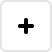
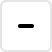
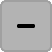
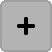
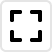
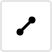
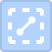
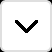
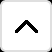
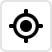
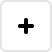
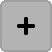
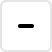
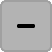
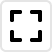
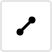
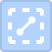
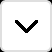
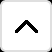
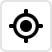

In [2]:
LetsPlot.setup_html()

In [3]:
df = pd.read_csv("https://raw.githubusercontent.com/JetBrains/lets-plot-docs/refs/heads/master/data/mpg.csv")
df["trans_type"] = df["trans"].str.split("(").str[0]
print(df.shape)
df.head()

(234, 13)


,Unnamed: 0,manufacturer,model,displ,year,cyl,trans,drv,cty,hwy,fl,class,trans_type
0,1,audi,a4,1.8,1999,4,auto(l5),f,18,29,p,compact,auto
1,2,audi,a4,1.8,1999,4,manual(m5),f,21,29,p,compact,manual
2,3,audi,a4,2.0,2008,4,manual(m6),f,20,31,p,compact,manual
3,4,audi,a4,2.0,2008,4,auto(av),f,21,30,p,compact,auto
4,5,audi,a4,2.8,1999,6,auto(l5),f,16,26,p,compact,auto


## Case 1: Uniform Width

Suppose we have the following plot, but we are not satisfied that different facets have different whisker widths:

In [4]:
ggplot(df) + \
    geom_errorbar(aes(as_discrete("trans", order=1), "hwy", color="trans_type"),
                  stat='summary', size=1, width=.5) + \
    facet_grid(x="year", scales="free_x")

We can make the widths uniform by setting the absolute unit of measurement for them.
For example, in pixels:

In [5]:
# Set width=30 and width_unit="px"
ggplot(df) + \
    geom_errorbar(aes(as_discrete("trans", order=1), "hwy", color="trans_type"),
                  stat='summary', size=1, width=30, width_unit="px") + \
    facet_grid(x="year", scales="free_x")

## Case 2: Matching the Grid

When using `geom_hex()` with the `'identity'` statistic, you must prepare the data yourself to fit into a hexagonal grid.

Let's assume you have prepared the following dataset:

In [6]:
def get_data(n, m, sizes, seed=42):
    np.random.seed(seed)
    def generate_full_dataset():
        return pd.DataFrame({
            'x': np.repeat(np.arange(n), m) + np.tile(([0, .5] * m)[:m], n),
            'y': np.tile(np.arange(m), n),
            'v': np.random.uniform(size=m*n),
        })
    def get_random_sample(df, size, reg=False):
        if reg:
            df = df[df['y'] % 2 == 0].sort_values(by=['x', 'y']).reset_index(drop=True)
        return df.sample(min(df.shape[0], size))
    return pd.concat([
        get_random_sample(generate_full_dataset(), size, reg=i==0).assign(g="group {0}".format(i))
        for i, size in enumerate(sizes)
    ])

df = get_data(6, 5, [8, 9, 7])
df.head()

,x,y,v,g
0,0.0,0,0.374540,group 0
5,1.0,4,0.708073,group 0
2,0.0,4,0.156019,group 0
15,5.0,0,0.785176,group 0
13,4.0,2,0.292145,group 0


The Lets-Plot tries to choose the sizes of the hexagons by itself, but in some situations the result may be unsatisfactory, as in the plot below. Namely in the facet with 'group 0', the hexagons are too large to fit into the grid:

In [7]:
ggplot(df, aes('x', 'y', fill='v')) + \
    geom_hex(stat='identity', size=.5) + \
    facet_wrap(facets='g', nrow=1)

In this case, simply resizing the hexagons is not enough. The default unit for width and height is `'res'`, and it depends on the resolution (minimum distance between hexagon centers) in a given facet:

In [8]:
ggplot(df, aes('x', 'y', fill='v')) + \
    geom_hex(stat='identity', size=.5,
             width=.5, height=.5) + \
    facet_wrap(facets='g', nrow=1)

However, you can change the units of measurement. If `width_unit='identity'`, the width of the hexagons will be expressed in X-axis units, and similarly for the height:

In [9]:
ggplot(df, aes('x', 'y', fill='v')) + \
    geom_hex(stat='identity', size=.5,
             width_unit='identity', width=1,
             height_unit='identity', height=2/sqrt(3)) + \
    facet_wrap(facets='g', nrow=1)

## Possible Values

The `width_unit` (or `height_unit`) parameter can take the following values:

- `'res'`: value 1 corresponds to the resolution along the axis, i.e. the minimum distance between data points;

- `'identity'`: value 1 corresponds to the distance from 0 to 1 on the axis;

- `'size'`: value 1 corresponds to the diameter of a point of size 1;

- `'px'`: value 1 corresponds to 1 pixel.

Let's look at them using the example of the `geom_tile()` geometry:

In [10]:
def get_plot(width, height, width_unit, height_unit):
    w, h = 7, 5
    data = {
        'x': [-w, -w, w, w],
        'y': [-h, h, -h, h],
        'c': ['a', 'b', 'c', 'd'],
    }
    return ggplot(data, aes('x', 'y', fill='c')) + \
        geom_tile(width=width, width_unit=width_unit,
                  height=height, height_unit=height_unit,
                  show_legend=False) + \
        geom_point(shape=21, fill="white") + \
        coord_fixed() + \
        ggtitle("width={w}, width_unit='{wu}'\nheight={h}, height_unit='{hu}'".format(
            w=width, wu=width_unit,
            h=height, hu=height_unit
        ))

gggrid([
    get_plot(.9, .9, 'res', 'res'),
    get_plot(12, 8, 'identity', 'identity'),
    get_plot(100, 70, 'size', 'size'),
    get_plot(200, 150, 'px', 'px'),
], ncol=2)